In [6]:
from IPython.display import Video
from pathlib import Path
import seaborn as sns
sns.set()

import pandas as pd
import numpy as np
import torch
import gym

import lagom
import lagom.utils as utils
import lagom.vis as vis


def get_configs(log_folder):
    data = utils.pickle_load(Path(log_folder) / 'configs.pkl')
    configs = pd.DataFrame(data, columns=data[0].keys())
    return configs


def make_video(make_env, agent_class, id_folder, seed, num_iter):
    id_folder = Path(id_folder)
    seed_folder = id_folder / str(seed)
    anim_folder = seed_folder / 'anim' 
    if not anim_folder.exists():
        anim_folder.mkdir(parents=True)

    config = lagom.Config(utils.yaml_load(id_folder / 'config.yml'))
    config.seed = seed
    config.device = torch.device('cpu')
    
    env = make_env(config, 'eval')
    assert isinstance(env, lagom.envs.TimeStepEnv)
    env = env.env  # strip out TimeStepEnv for some wrappers
    env = gym.wrappers.Monitor(env, anim_folder, force=True)
    if 'env.normalize_obs' in config and config['env.normalize_obs']:
        moments = np.load(seed_folder / f'obs_moments_{num_iter}.pth', allow_pickle=True)
        env = lagom.envs.NormalizeObservation(env, clip=5., constant_moments=moments)
    env = lagom.envs.TimeStepEnv(env)
    agent = agent_class(config, env)
    agent.load(seed_folder / f'agent_{num_iter}.pth')
    agent.eval()
    runner = lagom.EpisodeRunner()
    with torch.no_grad():
        [traj] = runner(agent, env, 1, mode='eval')
    env.close()
    print(f'Evaluation:\n\tHorizon: {traj.T}, Return: {sum(traj.rewards)}')
    return Video(list(anim_folder.glob('openaigym*000000.mp4'))[0])


err_kws = dict(kind='line', ci='sd', err_kws=dict(alpha=0.1))
layout_kws = dict(col='env.id', col_wrap=3, height=4, aspect=1.5,  # (4, 6) figsize
                  facet_kws=dict(sharex=True, sharey=False))

## Model-free RL
- [VPG](#VPG)
- [PPO](#PPO)
- [DDPG](#DDPG)
- [TD3](#TD3)
- [SAC](#SAC)

## ES
- [CEM](#CEM)
- [CMA-ES](#CMA-ES)

[Benchmarking](#Benchmarking)

## VPG

In [2]:
log_folder = 'vpg/logs/default/'
file_name = 'train_logs.pkl'
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['online_return'][0].mean

get_configs(log_folder)

,ID,log.freq,checkpoint.agent.num,checkpoint.resume.num,env.id,env.normalize_obs,env.normalize_reward,use_lstm,rnn.size,nn.sizes,...,agent.gamma,agent.gae_lambda,agent.standardize_adv,agent.max_grad_norm,agent.entropy_coef,agent.value_coef,env.clip_action,agent.std0,train.timestep,train.timestep_per_iter
0,0,10,3,3,HalfCheetah-v3,True,True,True,128,"[64, 64]",...,0.995,0.98,True,0.5,0.01,0.5,True,0.5,1000000,1000
1,1,10,3,3,HalfCheetah-v3,True,True,False,128,"[64, 64]",...,0.995,0.98,True,0.5,0.01,0.5,True,0.5,1000000,1000
2,2,10,3,3,Hopper-v3,True,True,True,128,"[64, 64]",...,0.995,0.98,True,0.5,0.01,0.5,True,0.5,1000000,1000
3,3,10,3,3,Hopper-v3,True,True,False,128,"[64, 64]",...,0.995,0.98,True,0.5,0.01,0.5,True,0.5,1000000,1000
4,4,10,3,3,Walker2d-v3,True,True,True,128,"[64, 64]",...,0.995,0.98,True,0.5,0.01,0.5,True,0.5,1000000,1000
5,5,10,3,3,Walker2d-v3,True,True,False,128,"[64, 64]",...,0.995,0.98,True,0.5,0.01,0.5,True,0.5,1000000,1000


In [3]:
data = vis.read_xy(log_folder, file_name, get_x, get_y, smooth_out=True, point_step=1)
data.head()

,x,y,ID,log.freq,checkpoint.agent.num,checkpoint.resume.num,env.id,env.normalize_obs,env.normalize_reward,use_lstm,...,agent.gamma,agent.gae_lambda,agent.standardize_adv,agent.max_grad_norm,agent.entropy_coef,agent.value_coef,env.clip_action,agent.std0,train.timestep,train.timestep_per_iter
0,1000,-199.779506,1.0,10.0,3.0,3.0,HalfCheetah-v3,True,True,False,...,0.995,0.98,True,0.5,0.01,0.5,True,0.5,1000000.0,1000.0
1,2000,-204.576913,1.0,10.0,3.0,3.0,HalfCheetah-v3,True,True,False,...,0.995,0.98,True,0.5,0.01,0.5,True,0.5,1000000.0,1000.0
2,3000,-208.947389,1.0,10.0,3.0,3.0,HalfCheetah-v3,True,True,False,...,0.995,0.98,True,0.5,0.01,0.5,True,0.5,1000000.0,1000.0
3,4000,-212.904349,1.0,10.0,3.0,3.0,HalfCheetah-v3,True,True,False,...,0.995,0.98,True,0.5,0.01,0.5,True,0.5,1000000.0,1000.0
4,5000,-216.461210,1.0,10.0,3.0,3.0,HalfCheetah-v3,True,True,False,...,0.995,0.98,True,0.5,0.01,0.5,True,0.5,1000000.0,1000.0


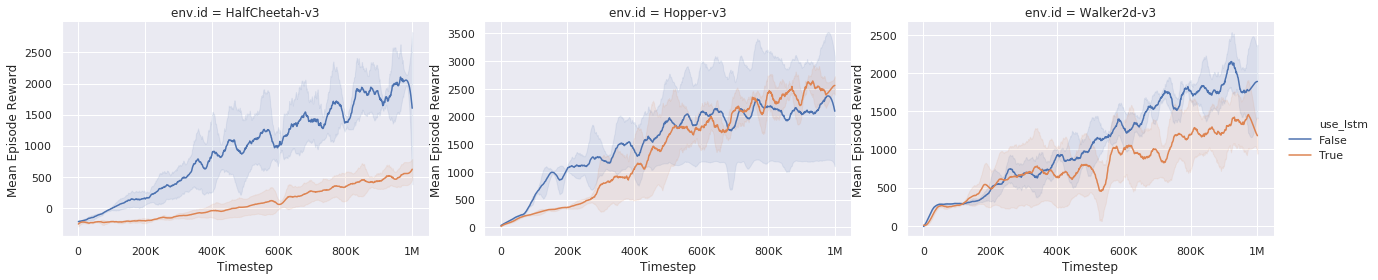

In [4]:
g = sns.relplot(data=data, x='x', y='y', hue='use_lstm', **err_kws, **layout_kws)
[vis.set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set(xlabel='Timestep', ylabel='Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [ ]:
from vpg.agent import Agent
from vpg.experiment import make_env
make_video(make_env, Agent, f'{log_folder}/0', seed=1284017742, num_iter=1001)

## PPO

In [8]:
log_folder = 'ppo/logs/default/'
file_name = 'train_logs.pkl'
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['online_return'][0].mean

get_configs(log_folder)

,ID,log.freq,checkpoint.agent.num,checkpoint.resume.num,env.id,env.normalize_obs,env.normalize_reward,agent.policy.sizes,agent.policy.lr,agent.value.sizes,...,agent.gae_lambda,agent.standardize_adv,agent.max_grad_norm,agent.clip_range,env.clip_action,agent.std0,train.timestep,train.timestep_per_iter,train.batch_size,train.num_epochs
0,0,10,3,3,HalfCheetah-v3,True,True,"[64, 64]",0.0003,"[64, 64]",...,0.95,True,0.5,0.2,True,0.4,1000000,2048,64,10
1,1,10,3,3,Hopper-v3,True,True,"[64, 64]",0.0003,"[64, 64]",...,0.95,True,0.5,0.2,True,0.4,1000000,2048,64,10
2,2,10,3,3,Walker2d-v3,True,True,"[64, 64]",0.0003,"[64, 64]",...,0.95,True,0.5,0.2,True,0.4,1000000,2048,64,10


In [9]:
data = vis.read_xy(log_folder, file_name, get_x, get_y, smooth_out=True, point_step=1)
data.head()

,x,y,ID,log.freq,checkpoint.agent.num,checkpoint.resume.num,env.id,env.normalize_obs,env.normalize_reward,agent.policy.sizes,...,agent.gae_lambda,agent.standardize_adv,agent.max_grad_norm,agent.clip_range,env.clip_action,agent.std0,train.timestep,train.timestep_per_iter,train.batch_size,train.num_epochs
0,2048,50.175289,1.0,10.0,3.0,3.0,Hopper-v3,True,True,"(64, 64)",...,0.95,True,0.5,0.2,True,0.4,1000000.0,2048.0,64.0,10.0
1,4096,71.400770,1.0,10.0,3.0,3.0,Hopper-v3,True,True,"(64, 64)",...,0.95,True,0.5,0.2,True,0.4,1000000.0,2048.0,64.0,10.0
2,6144,91.528059,1.0,10.0,3.0,3.0,Hopper-v3,True,True,"(64, 64)",...,0.95,True,0.5,0.2,True,0.4,1000000.0,2048.0,64.0,10.0
3,8192,110.594701,1.0,10.0,3.0,3.0,Hopper-v3,True,True,"(64, 64)",...,0.95,True,0.5,0.2,True,0.4,1000000.0,2048.0,64.0,10.0
4,10240,128.638239,1.0,10.0,3.0,3.0,Hopper-v3,True,True,"(64, 64)",...,0.95,True,0.5,0.2,True,0.4,1000000.0,2048.0,64.0,10.0


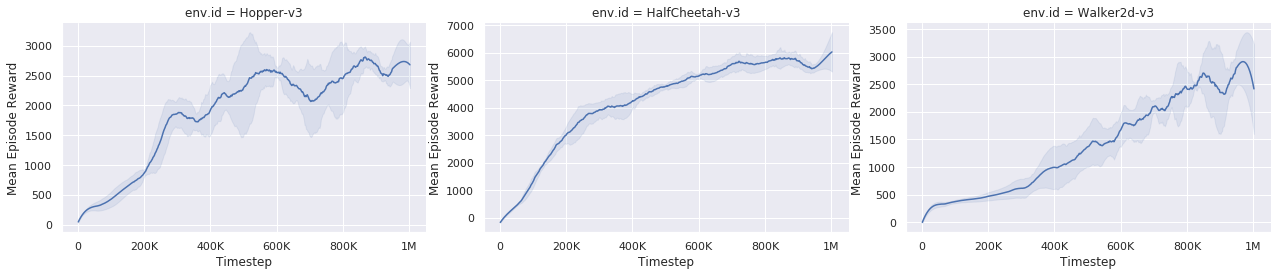

In [10]:
g = sns.relplot(data=data, x='x', y='y', hue=None, **err_kws, **layout_kws)
[vis.set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set(xlabel='Timestep', ylabel='Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [ ]:
from ppo.agent import Agent
from ppo.experiment import make_env
make_video(make_env, Agent, f'{log_folder}/0', seed=1284017742, num_iter=490)

## DDPG

In [11]:
log_folder = 'ddpg/logs/default/'
file_name = 'eval_logs.pkl'
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['online_return'][0].mean

get_configs(log_folder)

,ID,log.freq,checkpoint.agent.num,checkpoint.resume.num,env.id,agent.gamma,agent.polyak,agent.actor.sizes,agent.actor.lr,agent.critic.sizes,agent.critic.lr,agent.action_noise,replay.capacity,replay.init_trial,replay.batch_size,train.timestep,eval.num
0,0,10,3,3,HalfCheetah-v3,0.99,0.995,"[400, 300]",0.001,"[400, 300]",0.001,0.1,1000000,10,100,1000000,200
1,1,10,3,3,Hopper-v3,0.99,0.995,"[400, 300]",0.001,"[400, 300]",0.001,0.1,1000000,10,100,1000000,200
2,2,10,3,3,Walker2d-v3,0.99,0.995,"[400, 300]",0.001,"[400, 300]",0.001,0.1,1000000,10,100,1000000,200


In [12]:
data = vis.read_xy(log_folder, file_name, get_x, get_y, smooth_out=True, point_step=1)
data.head()

,x,y,ID,log.freq,checkpoint.agent.num,checkpoint.resume.num,env.id,agent.gamma,agent.polyak,agent.actor.sizes,agent.actor.lr,agent.critic.sizes,agent.critic.lr,agent.action_noise,replay.capacity,replay.init_trial,replay.batch_size,train.timestep,eval.num
0,13,-32.033770,1.0,10.0,3.0,3.0,Hopper-v3,0.99,0.995,"(400, 300)",0.001,"(400, 300)",0.001,0.1,1000000.0,10.0,100.0,1000000.0,200.0
1,15,-7.332365,1.0,10.0,3.0,3.0,Hopper-v3,0.99,0.995,"(400, 300)",0.001,"(400, 300)",0.001,0.1,1000000.0,10.0,100.0,1000000.0,200.0
2,21,15.975981,1.0,10.0,3.0,3.0,Hopper-v3,0.99,0.995,"(400, 300)",0.001,"(400, 300)",0.001,0.1,1000000.0,10.0,100.0,1000000.0,200.0
3,24,37.943577,1.0,10.0,3.0,3.0,Hopper-v3,0.99,0.995,"(400, 300)",0.001,"(400, 300)",0.001,0.1,1000000.0,10.0,100.0,1000000.0,200.0
4,50,58.622731,1.0,10.0,3.0,3.0,Hopper-v3,0.99,0.995,"(400, 300)",0.001,"(400, 300)",0.001,0.1,1000000.0,10.0,100.0,1000000.0,200.0


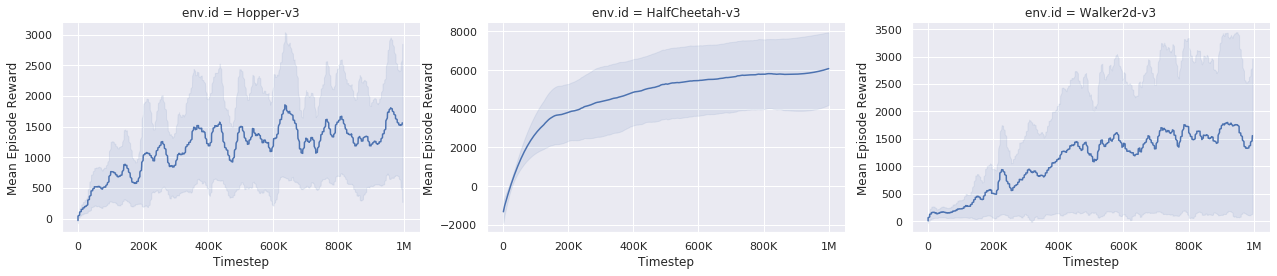

In [13]:
g = sns.relplot(data=data, x='x', y='y', hue=None, **err_kws, **layout_kws)
[vis.set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set(xlabel='Timestep', ylabel='Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [ ]:
from ddpg.agent import Agent
from ddpg.experiment import make_env
make_video(make_env, Agent, f'{log_folder}/0', seed=1284017742, num_iter=1001)

## TD3

In [14]:
log_folder = 'td3/logs/default/'
file_name = 'eval_logs.pkl'
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['online_return'][0].mean

get_configs(log_folder)

,ID,log.freq,checkpoint.agent.num,checkpoint.resume.num,env.id,agent.gamma,agent.polyak,agent.actor.sizes,agent.actor.lr,agent.critic.sizes,agent.critic.lr,agent.action_noise,agent.target_noise,agent.target_noise_clip,agent.policy_delay,replay.capacity,replay.init_trial,replay.batch_size,train.timestep,eval.num
0,0,10,3,1,HalfCheetah-v3,0.99,0.995,"[256, 256]",0.0003,"[256, 256]",0.0003,0.1,0.2,0.5,2,1000000,10,256,1000000,200
1,1,10,3,1,Hopper-v3,0.99,0.995,"[256, 256]",0.0003,"[256, 256]",0.0003,0.1,0.2,0.5,2,1000000,10,256,1000000,200
2,2,10,3,1,Walker2d-v3,0.99,0.995,"[256, 256]",0.0003,"[256, 256]",0.0003,0.1,0.2,0.5,2,1000000,10,256,1000000,200


In [15]:
data = vis.read_xy(log_folder, file_name, get_x, get_y, smooth_out=True, point_step=1)
data.head()

,x,y,ID,log.freq,checkpoint.agent.num,checkpoint.resume.num,env.id,agent.gamma,agent.polyak,agent.actor.sizes,...,agent.critic.lr,agent.action_noise,agent.target_noise,agent.target_noise_clip,agent.policy_delay,replay.capacity,replay.init_trial,replay.batch_size,train.timestep,eval.num
0,11,-38.669997,1.0,10.0,3.0,1.0,Hopper-v3,0.99,0.995,"(256, 256)",...,0.0003,0.1,0.2,0.5,2.0,1000000.0,10.0,256.0,1000000.0,200.0
1,16,-22.205956,1.0,10.0,3.0,1.0,Hopper-v3,0.99,0.995,"(256, 256)",...,0.0003,0.1,0.2,0.5,2.0,1000000.0,10.0,256.0,1000000.0,200.0
2,19,-6.180994,1.0,10.0,3.0,1.0,Hopper-v3,0.99,0.995,"(256, 256)",...,0.0003,0.1,0.2,0.5,2.0,1000000.0,10.0,256.0,1000000.0,200.0
3,25,9.404743,1.0,10.0,3.0,1.0,Hopper-v3,0.99,0.995,"(256, 256)",...,0.0003,0.1,0.2,0.5,2.0,1000000.0,10.0,256.0,1000000.0,200.0
4,27,24.551112,1.0,10.0,3.0,1.0,Hopper-v3,0.99,0.995,"(256, 256)",...,0.0003,0.1,0.2,0.5,2.0,1000000.0,10.0,256.0,1000000.0,200.0


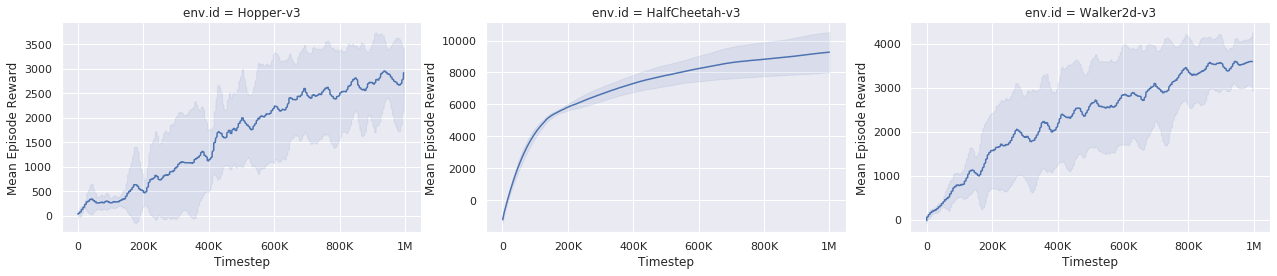

In [16]:
g = sns.relplot(data=data, x='x', y='y', hue=None, **err_kws, **layout_kws)
[vis.set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set(xlabel='Timestep', ylabel='Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [ ]:
from td3.agent import Agent
from td3.experiment import make_env
make_video(make_env, Agent, f'{log_folder}/0', seed=1284017742, num_iter=1001)

## SAC

In [17]:
log_folder = 'sac/logs/default/'
file_name = 'eval_logs.pkl'
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['online_return'][0].mean

get_configs(log_folder)

,ID,log.freq,checkpoint.agent.num,checkpoint.resume.num,env.id,agent.gamma,agent.polyak,agent.actor.sizes,agent.actor.lr,agent.critic.sizes,agent.critic.lr,agent.initial_temperature,replay.capacity,replay.init_trial,replay.batch_size,train.timestep,eval.num
0,0,10,3,1,HalfCheetah-v3,0.99,0.995,"[256, 256]",0.0003,"[256, 256]",0.0003,1.0,1000000,10,256,1000000,200
1,1,10,3,1,Hopper-v3,0.99,0.995,"[256, 256]",0.0003,"[256, 256]",0.0003,1.0,1000000,10,256,1000000,200
2,2,10,3,1,Walker2d-v3,0.99,0.995,"[256, 256]",0.0003,"[256, 256]",0.0003,1.0,1000000,10,256,1000000,200


In [18]:
data = vis.read_xy(log_folder, file_name, get_x, get_y, smooth_out=True, point_step=1)
data.head()

,x,y,ID,log.freq,checkpoint.agent.num,checkpoint.resume.num,env.id,agent.gamma,agent.polyak,agent.actor.sizes,agent.actor.lr,agent.critic.sizes,agent.critic.lr,agent.initial_temperature,replay.capacity,replay.init_trial,replay.batch_size,train.timestep,eval.num
0,11,220.058094,1.0,10.0,3.0,1.0,Hopper-v3,0.99,0.995,"(256, 256)",0.0003,"(256, 256)",0.0003,1.0,1000000.0,10.0,256.0,1000000.0,200.0
1,15,224.743190,1.0,10.0,3.0,1.0,Hopper-v3,0.99,0.995,"(256, 256)",0.0003,"(256, 256)",0.0003,1.0,1000000.0,10.0,256.0,1000000.0,200.0
2,21,229.907298,1.0,10.0,3.0,1.0,Hopper-v3,0.99,0.995,"(256, 256)",0.0003,"(256, 256)",0.0003,1.0,1000000.0,10.0,256.0,1000000.0,200.0
3,30,235.526976,1.0,10.0,3.0,1.0,Hopper-v3,0.99,0.995,"(256, 256)",0.0003,"(256, 256)",0.0003,1.0,1000000.0,10.0,256.0,1000000.0,200.0
4,5017,241.578781,1.0,10.0,3.0,1.0,Hopper-v3,0.99,0.995,"(256, 256)",0.0003,"(256, 256)",0.0003,1.0,1000000.0,10.0,256.0,1000000.0,200.0


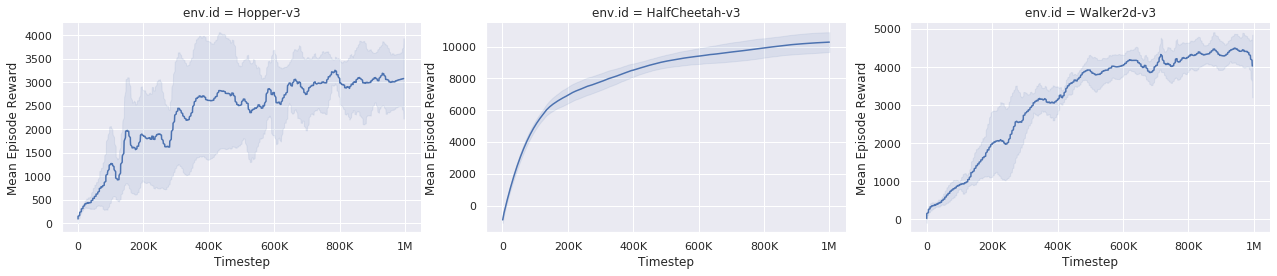

In [19]:
g = sns.relplot(data=data, x='x', y='y', hue=None, **err_kws, **layout_kws)
[vis.set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set(xlabel='Timestep', ylabel='Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [ ]:
from sac.agent import Agent
from sac.experiment import make_env
make_video(make_env, Agent, f'{log_folder}/0', seed=1284017742, num_iter=1001)

## CEM

In [20]:
log_folder = 'cem/logs/default/'
file_name = 'train_logs.pkl'
get_x = lambda log: log['generation'][0]
get_y = lambda log: log['Returns'][0].mean

get_configs(log_folder)

,ID,log.freq,checkpoint.agent.num,checkpoint.resume.num,env.id,nn.sizes,train.generations,train.popsize,train.worker_chunksize,train.mu0,train.std0,train.elite_ratio,train.noise_scheduler_args
0,0,10,3,5,CartPole-v1,"[32, 32]",300,32,4,0.0,1.0,0.25,"[0.01, 0.001, 300, 0]"
1,1,10,3,5,Pendulum-v0,"[32, 32]",300,32,4,0.0,1.0,0.25,"[0.01, 0.001, 300, 0]"


In [21]:
data = vis.read_xy(log_folder, file_name, get_x, get_y, smooth_out=True, point_step=1)
data.head()

,x,y,ID,log.freq,checkpoint.agent.num,checkpoint.resume.num,env.id,nn.sizes,train.generations,train.popsize,train.worker_chunksize,train.mu0,train.std0,train.elite_ratio,train.noise_scheduler_args
0,1,-1497.700368,1.0,10.0,3.0,5.0,Pendulum-v0,"(32, 32)",300.0,32.0,4.0,0.0,1.0,0.25,"(0.01, 0.001, 300, 0)"
1,2,-1477.851806,1.0,10.0,3.0,5.0,Pendulum-v0,"(32, 32)",300.0,32.0,4.0,0.0,1.0,0.25,"(0.01, 0.001, 300, 0)"
2,3,-1458.066742,1.0,10.0,3.0,5.0,Pendulum-v0,"(32, 32)",300.0,32.0,4.0,0.0,1.0,0.25,"(0.01, 0.001, 300, 0)"
3,4,-1438.366483,1.0,10.0,3.0,5.0,Pendulum-v0,"(32, 32)",300.0,32.0,4.0,0.0,1.0,0.25,"(0.01, 0.001, 300, 0)"
4,5,-1418.772335,1.0,10.0,3.0,5.0,Pendulum-v0,"(32, 32)",300.0,32.0,4.0,0.0,1.0,0.25,"(0.01, 0.001, 300, 0)"


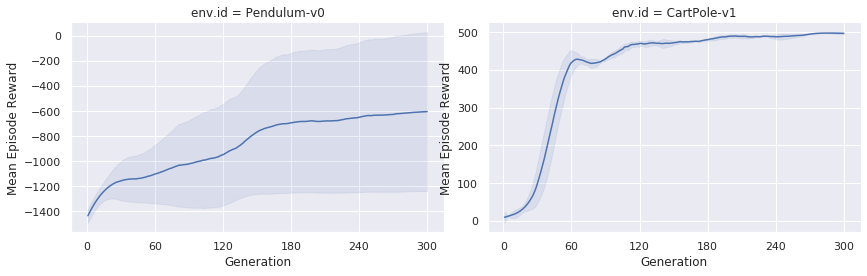

In [22]:
g = sns.relplot(data=data, x='x', y='y', hue=None, **err_kws, **layout_kws)
[vis.set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set(xlabel='Generation', ylabel='Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [ ]:
from cem.agent import Agent
from cem.experiment import make_env
make_video(make_env, Agent, f'{log_folder}/0', seed=1284017742, num_iter=301)

### CMA-ES

In [24]:
log_folder = 'cmaes/logs/default/'
file_name = 'train_logs.pkl'
get_x = lambda log: log['generation'][0]
get_y = lambda log: log['Returns'][0].mean

get_configs(log_folder)

,ID,log.freq,checkpoint.agent.num,checkpoint.resume.num,env.id,nn.sizes,train.generations,train.popsize,train.worker_chunksize,train.mu0,train.std0
0,0,10,3,5,CartPole-v1,"[32, 32]",300,32,4,0.0,1.0
1,1,10,3,5,Pendulum-v0,"[32, 32]",300,32,4,0.0,1.0


In [25]:
data = vis.read_xy(log_folder, file_name, get_x, get_y, smooth_out=True, point_step=1)
data.head()

,x,y,ID,log.freq,checkpoint.agent.num,checkpoint.resume.num,env.id,nn.sizes,train.generations,train.popsize,train.worker_chunksize,train.mu0,train.std0
0,1,-1472.879917,1.0,10.0,3.0,5.0,Pendulum-v0,"(32, 32)",300.0,32.0,4.0,0.0,1.0
1,2,-1460.928822,1.0,10.0,3.0,5.0,Pendulum-v0,"(32, 32)",300.0,32.0,4.0,0.0,1.0
2,3,-1449.110193,1.0,10.0,3.0,5.0,Pendulum-v0,"(32, 32)",300.0,32.0,4.0,0.0,1.0
3,4,-1437.432989,1.0,10.0,3.0,5.0,Pendulum-v0,"(32, 32)",300.0,32.0,4.0,0.0,1.0
4,5,-1425.906169,1.0,10.0,3.0,5.0,Pendulum-v0,"(32, 32)",300.0,32.0,4.0,0.0,1.0


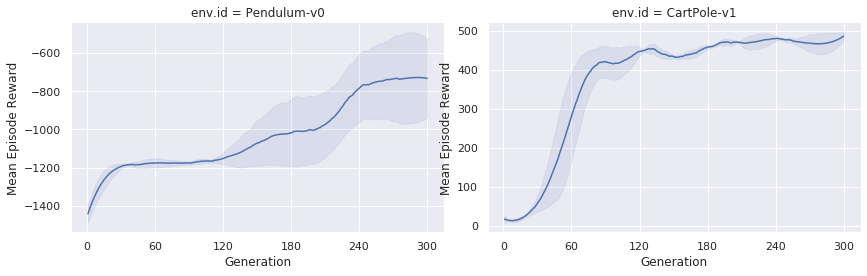

In [26]:
g = sns.relplot(data=data, x='x', y='y', hue=None, **err_kws, **layout_kws)
[vis.set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set(xlabel='Generation', ylabel='Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [ ]:
from cmaes.agent import Agent
from cmaes.experiment import make_env
make_video(make_env, Agent, f'{log_folder}/0', seed=1284017742, num_iter=301)

## Benchmarking

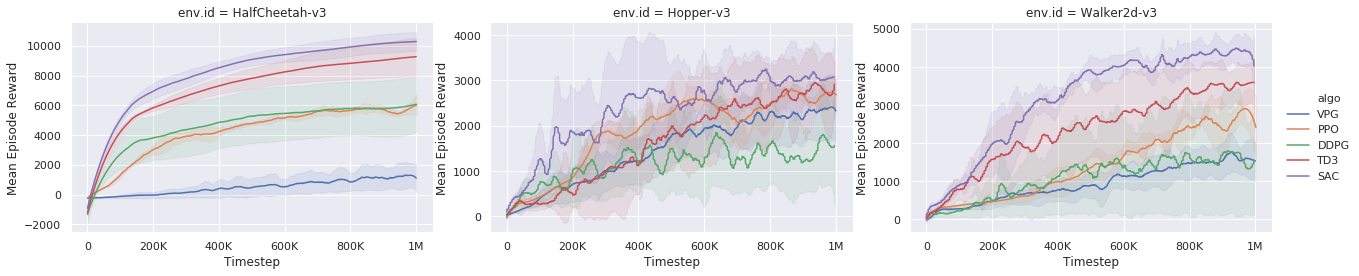

In [27]:
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['online_return'][0].mean

data = []
d = vis.read_xy('vpg/logs/default', 'train_logs.pkl', get_x, get_y, smooth_out=True, point_step=1)
d['algo'] = 'VPG'
data.append(d)
d = vis.read_xy('ppo/logs/default', 'train_logs.pkl', get_x, get_y, smooth_out=True, point_step=1)
d['algo'] = 'PPO'
data.append(d)
d = vis.read_xy('ddpg/logs/default', 'eval_logs.pkl', get_x, get_y, smooth_out=True, point_step=1)
d['algo'] = 'DDPG'
data.append(d)
d = vis.read_xy('td3/logs/default', 'eval_logs.pkl', get_x, get_y, smooth_out=True, point_step=1)
d['algo'] = 'TD3'
data.append(d)
d = vis.read_xy('sac/logs/default', 'eval_logs.pkl', get_x, get_y, smooth_out=True, point_step=1)
d['algo'] = 'SAC'
data.append(d)
data = pd.concat(data, ignore_index=True, sort=False)

g = sns.relplot(data=data, x='x', y='y', hue='algo', **err_kws, **layout_kws)
[vis.set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set(xlabel='Timestep', ylabel='Mean Episode Reward')
g.savefig(f'benchmark_rl.png')

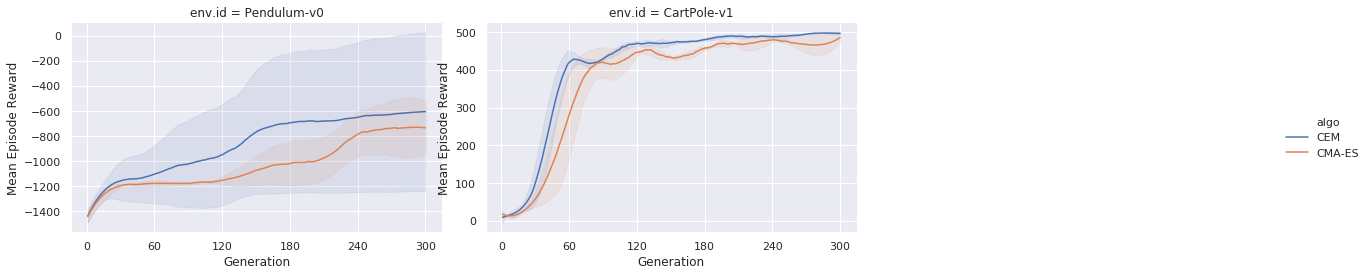

In [28]:
file_name = 'train_logs.pkl'
get_x = lambda log: log['generation'][0]
get_y = lambda log: log['Returns'][0].mean

data = []
d = vis.read_xy('cem/logs/default', file_name, get_x, get_y, smooth_out=True, point_step=1)
d['algo'] = 'CEM'
data.append(d)
d = vis.read_xy('cmaes/logs/default', file_name, get_x, get_y, smooth_out=True, point_step=1)
d['algo'] = 'CMA-ES'
data.append(d)
data = pd.concat(data, ignore_index=True, sort=False)

g = sns.relplot(data=data, x='x', y='y', hue='algo', **err_kws, **layout_kws)
[vis.set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set(xlabel='Generation', ylabel='Mean Episode Reward')
g.savefig(f'benchmark_es.png')